### Data Preparation for Bayesian Filter

install dependencies....

In [1]:
!pip install beautifulsoup4

In [2]:
!pip install wordcloud

In [3]:
#we are importing all the libraries we would like to use.
#including data stores for stopwords and such
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import os
import io
%matplotlib inline

### This function reads the files in the specified path.

In [4]:
def read_files(path):
    #this function is reading the actual email files.
    #the function will cycle through all the files in the folder specified.
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root,filename)
            
            inBody = False
            lines = []
            #this uses IO functions to read the files by specifying the encoding type
            f = io.open(path, 'r', encoding = 'latin1')
            #this cycles through each line and fetches the text therein.
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            #join the text into a single message.
            message = '\n'.join(lines)
            #return the message
            yield path, message
                    

### This function is for creating dataframes from the dataset in question... it also classifies the emails into either ham or spam

In [5]:
#this classifies the emails into spam or ham depending on predetermined status.
def dataFrameFromDirectory(path, classification):
    #instantiate the structure of the dataframe needed.
    rows = []
    index = []
    #store the message alongside its classification.
    for filename, message in read_files(path):
        rows.append({'message': message, 'label': classification})
        index.append(filename)
        #return the dataframe to be used for manipulation
    return pd.DataFrame(rows, index=index)

aggregate all the emails into a single dataframe. The key is: ham = 0, spam = 1

In [6]:
#fetch the data from the source files.
#here you run the datasets sequentially for validation by specifying file name. 

data = pd.DataFrame({'message':[],'label':[]})
data = data.append(dataFrameFromDirectory("datasets/ham1",0))
data = data.append(dataFrameFromDirectory("datasets/spam1",1))
data

,message,label
datasets/ham1/0582.adc6095d8af63a380672cfd1e881a586,> This is getting better and better. You know ...,0.0
datasets/ham1/1017.d946df144440633b63b4df3fa3c6082b,"From the local paper this morning.\n\n""Canadi...",0.0
datasets/ham1/2002.4aee6e78ce794e84f44ccde11f46fd4c,URL: http://boingboing.net/#85485786\n\nDate: ...,0.0
datasets/ham1/1369.0df084ff7488653baa03642c485c233f,humberto@hpcf.upr.edu wrote:\n\n\n\n>Redhat 8 ...,0.0
datasets/ham1/0862.91f1d92f60d5789a201c14f2034bbdaa,"On Saturday, September 28, 2002, at 12:54 PM, ...",0.0
...,...,...
datasets/spam1/0149.3300ef4537e1f6accd4489125bef5b0d,###################################\n\n\n\n F...,1.0
datasets/spam1/0322.77dd826a00ebd4b54a6036394d41da55,"ilug ,\n\n\n\n From;Mr.Michael Kamah and Fami...",1.0
datasets/spam1/0105.9790e1c57fcbf7885b7cd1719fb4681b,1) Join the Web's Hottest & Fastest Growing Co...,1.0
datasets/spam1/0137.42d5881a50744e24d9280701bb534cfb,<!-- saved from url=(0022)http://internet.e-ma...,1.0


The below cell shows the number of rows in our dataframe.

In [7]:
total_mails = data['message'].shape[0]
total_mails

300

The function below extracts all text from html text present in all emails.

In [8]:
#this is for scraping the emails, since most are in the form of html based content.
from bs4 import BeautifulSoup

def func(df):
    soup = BeautifulSoup(df['message'], "html.parser").find()
    #check emails with html syntax
    if bool(soup):
        soup = BeautifulSoup(df['message'], "html.parser")
        #extract text only from the whole email.
    
        text = soup.find_all(text=True)
      
        #return all the words found.
        text = ''.join(word for word in  text)
        df['message'] = text
        
        return text
    else:
        
        return df['message'] 

In [9]:
import email

def using_emailing_function(df):

#     msg = email.message_from_string(df['message'])
#     for part in msg.walk():
#         print(df['message'])
        
    msg = email.message_from_string(df['message'])
    if msg.is_multipart():
        for payload in msg.get_payload():
            # if payload.is_multipart(): ...
#             print(payload.get_payload())
            soup = BeautifulSoup(payload.get_payload(), "lxml").find()
            if bool(soup):
                print(payload.get_payload())
            else:
                print(payload.get_payload())
    else:
        soup = BeautifulSoup(msg.get_payload(), "lxml").find()
        if bool(soup):
                print(msg.get_payload())
#         else:
#             print(msg.get_payload())



In [10]:
new_data = data.reset_index()
new_data

,index,message,label
0,datasets/ham1/0582.adc6095d8af63a380672cfd1e88...,> This is getting better and better. You know ...,0.0
1,datasets/ham1/1017.d946df144440633b63b4df3fa3c...,"From the local paper this morning.\n\n""Canadi...",0.0
2,datasets/ham1/2002.4aee6e78ce794e84f44ccde11f4...,URL: http://boingboing.net/#85485786\n\nDate: ...,0.0
3,datasets/ham1/1369.0df084ff7488653baa03642c485...,humberto@hpcf.upr.edu wrote:\n\n\n\n>Redhat 8 ...,0.0
4,datasets/ham1/0862.91f1d92f60d5789a201c14f2034...,"On Saturday, September 28, 2002, at 12:54 PM, ...",0.0
...,...,...,...
295,datasets/spam1/0149.3300ef4537e1f6accd4489125b...,###################################\n\n\n\n F...,1.0
296,datasets/spam1/0322.77dd826a00ebd4b54a6036394d...,"ilug ,\n\n\n\n From;Mr.Michael Kamah and Fami...",1.0
297,datasets/spam1/0105.9790e1c57fcbf7885b7cd1719f...,1) Join the Web's Hottest & Fastest Growing Co...,1.0
298,datasets/spam1/0137.42d5881a50744e24d9280701bb...,<!-- saved from url=(0022)http://internet.e-ma...,1.0


In [11]:
#this removes all text that is not alphanumeric i.e special characters.
new_data[new_data['message'].str.isalnum()]

,index,message,label


split the data into the pareto principle for unbiased model testing.
so 80% will be used for training and 20% for testing.
this will be accomplished by using a random number generator to randomize the order by implementing a uniform distribution randomizer. this removes all chances of having a biased model on account of sequential data.

In [12]:
#split the data into training and testing sets
#initializing empty lists to hold training and testing data respectively
train_index, test_index = list(), list()
for i in range(data['message'].shape[0]):
    #make use of the uniform random distribution to alleviate contiguousness of pseudo-random number generators.
    #80% for training and 20% for testing according to the pareto principle.
    if np.random.uniform(0,1) < 0.80:
        train_index.append(i)
    else:
        test_index.append(i)
#training data dataframe.
train_data = new_data.loc[train_index]
#test data dataframe
test_data = new_data.loc[test_index]

In [13]:
train_data.apply(using_emailing_function, axis = 1) 

> This is getting better and better. You know 3K is utter shite how? 



I'm not going to be your spokesman, Eugen.  Figure it out yourself.



over and out.







"Canadians eat about seven times as many doughnuts per capita"... (as 

Americans) . D'oh!



Owen







humberto@hpcf.upr.edu wrote:



>Redhat 8 disables all support for .mp3 files, relinking xmms with a zzmp3 

>module. Does anyone have a fixed spec file for xmms? One that can play mp3's 

>would be best.

>

>  

>

oh xmms didn't work for me also

i used mpg123 i tought its something from me

like mplayer not working also and gives black screen













_______________________________________________

RPM-List mailing list <RPM-List@freshrpms.net>

http://lists.freshrpms.net/mailman/listinfo/rpm-list





Date: Not supplied



Mena sez: "We've set up a TrackBack ping repository for attendees of O'Reilly's 

Mac OS X Conference. If you're using Movable Type or a TrackBack-enabled tool, 

you can ping the category r

she read the links. what must it be like, she wondered, to devote ones life

to pointing out  neighbors' mistakes, mishaps, inconsistencies and

frailties?



gloating is definitely underrated in the good book - eh, john?



bring it on,

gg



-----Original Message-----

From: fork-admin@xent.com [mailto:fork-admin@xent.com]On Behalf Of John

Hall

Sent: Saturday, October 05, 2002 11:56 PM

To: FoRK

Subject: Our friends the Palestinians, Our servants in government.









Hijacker High (8/30)

Dalal Mughrabi was a Palestinian woman who participated in a 1978 bus

hijacking in which 36 Israelis and an American nature photographer, Gail

Ruban, were killed. Mughrabi has a Palestinian high school named after

her, and it's apparently starting to show signs of wear. Fortunately,

the United States Agency for International Development has stepped in

with money to help renovate it.



http://reason.com/brickbats/bb-april.shtml



Links to:



http://www.cnsnews.com/ViewForeignBureaus.as

<html>

<head>

</head>

<body>

<p align="center"><font style="font-size: 11pt" face="Courier">Volume 8, Issue 35 - Sept. 2002</font></p>

<p align="center"><b><a href="http://www.globalcybercollective.com/BBAN_9_2002.htm">CLICK HERE</a></b></p>

<p align="center"><img border="0" src="http://www.globalcybercollective.com/WSBulletinEmail5.bmp"></p>

<p align="left">&nbsp;</p>

<p align="left">&nbsp;</p>

<p align="center"><font size="2">I no longer wish to receive your newsletter <a href="mailto:WSB20000@444.net?subject=takeoff"><b>click here</b></a></font></p>

</body>

</html>



urfrdemubblkunmdbyh





This is a multi-part message in MIME format.



------=_NextPart_000_26B382_01C24DC8.0B7C5210

Content-Type: text/plain;

	charset="iso-8859-1"

Content-Transfer-Encoding: 7bit



1) Join the Web's Hottest & Fastest Growing Community

It Is So Hot! <http://www.adclick.ws/p.cfm?o=259&s=pk007> 



2) Guaranteed to lose 10-12 lbs in 30 days

Slim Patch - Weight Loss Patches

<http://www

0      None
1      None
3      None
5      None
6      None
       ... 
294    None
295    None
297    None
298    None
299    None
Length: 241, dtype: object

implement the data cleaning of the html based messages
    

In [14]:
#here we  apply the scraping function to our data. hence cleaning it.
train_data['message'] = train_data.apply(func, axis=1)
test_data['message'] = test_data.apply(func, axis=1)
train_data #its just expecting the data to come from a website and not a dataframe.

,index,message,label
0,datasets/ham1/0582.adc6095d8af63a380672cfd1e88...,> This is getting better and better. You know ...,0.0
1,datasets/ham1/1017.d946df144440633b63b4df3fa3c...,"From the local paper this morning.\n\n""Canadi...",0.0
3,datasets/ham1/1369.0df084ff7488653baa03642c485...,humberto@hpcf.upr.edu wrote:\n\n\n\n>Redhat 8 ...,0.0
5,datasets/ham1/2301.12cd963ea74e881168b6bb865de...,URL: http://boingboing.net/#85511996\n\nDate: ...,0.0
6,datasets/ham1/2219.a6bcfc52346ca02a2add2951167...,"URL: http://www.newsisfree.com/click/-1,840289...",0.0
...,...,...,...
294,datasets/spam1/0475.f3c5fb57463eb715fa93e9ce48...,Protect your financial well-being.\n\nPurchase...,1.0
295,datasets/spam1/0149.3300ef4537e1f6accd4489125b...,###################################\n\n\n\n F...,1.0
297,datasets/spam1/0105.9790e1c57fcbf7885b7cd1719f...,1) Join the Web's Hottest & Fastest Growing Co...,1.0
298,datasets/spam1/0137.42d5881a50744e24d9280701bb...,saved from url=(0022)http://internet.e-mail \...,1.0


In [15]:
import re #regular expression. it is used to perform word searches.

train_data['message'] = train_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))
test_data['message'] = test_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))

In [16]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [17]:
train_data['message'].str.isalnum()

0      False
1      False
2      False
3      False
4      False
       ...  
236    False
237    False
238    False
239    False
240    False
Name: message, Length: 241, dtype: bool

In [18]:
test_data

,index,message,label
0,datasets/ham1/2002.4aee6e78ce794e84f44ccde11f4...,URL http boingboing net 85485786 Date Not supp...,0.0
1,datasets/ham1/0862.91f1d92f60d5789a201c14f2034...,On Saturday September 28 2002 at 12 54 PM Gary...,0.0
2,datasets/ham1/0422.cf8753c2ab03fedf1c9a2d8fb1c...,Eirikur Hallgrimsson said Let me ask you If y...,0.0
3,datasets/ham1/2327.99f03eb7cff9374e1748636eb16...,URL http www newsisfree com click 215 1 215 Da...,0.0
4,datasets/ham1/0114.72c7d2d85d9d99ce3ce268d0914...,Adam Beberg Considering 90 of the fake job pos...,0.0
5,datasets/ham1/1765.4257318f87e53aa246882d00e42...,Jeremy Hylton I think one step towards deploy...,0.0
6,datasets/ham1/1428.5b9b341ac8488e65419bd551ce9...,wLAMOaPNJ0fu1fTG Content Type text plain char...,0.0
7,datasets/ham1/2170.78c282a5e417d6d231dc75aa858...,URL http www newsisfree com click 1 8381145 21...,0.0
8,datasets/ham1/2196.398bf8908844f5f3beb83f270f4...,URL http diveintomark org archives 2002 09 30 ...,0.0
9,datasets/ham1/1316.e019de5bb870ed83dc036c657cc...,Once upon a time Roi wrote Since I upgraded to...,0.0


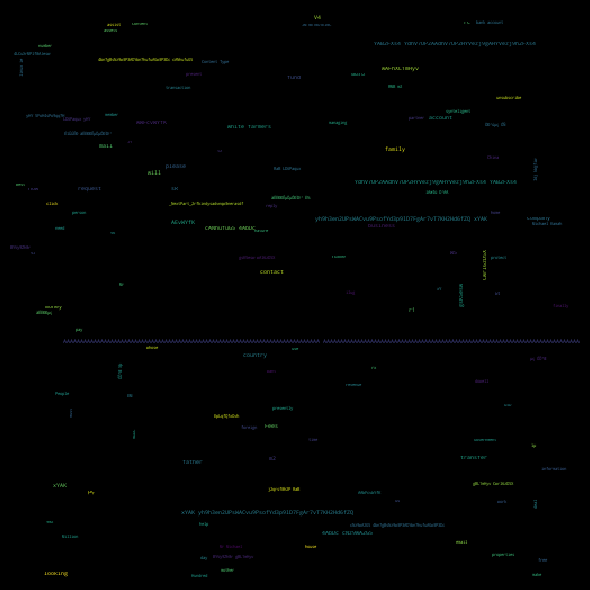

In [19]:
#visual representation of the most salient words.
#this is the visulization for the spam.
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 1]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

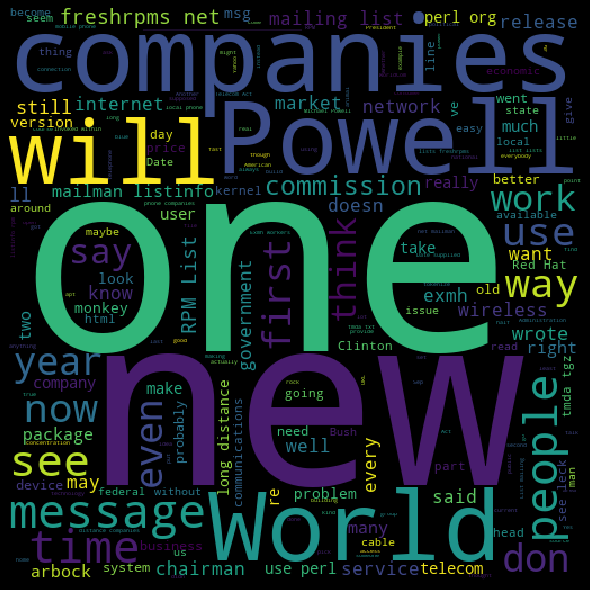

In [20]:
#Visualize the ham data
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 0]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

distribution by value

In [21]:
train_data['label'].value_counts() #remove the paragraph line

0.0    199
1.0     42
Name: label, dtype: int64

In [22]:
#tokenizing and processing the words harnessed.
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    #lower case all the letters in the message.
    if lower_case:
        message = message.lower()
    #break down the words into tokens.
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
#     print(words)
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        #fetch all words that do not have meaning in this case: stopwords.
        sw = stopwords.words('english')
        #create a list of words containing only the words without stopwords
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
#     print(words)
    return words

In [23]:
train_data.columns

Index(['index', 'message', 'label'], dtype='object')

In [24]:
#this whole function is the bayesian classifier. the calc_prob calculates the probability of a word bein either spam or ham.
#the classify function returns true if the threshold for it being spam has been reached. otherwise, it is false, meaning ham.
class SpamClassifier(object):
    def __init__(self, train_data, method = 'tf-idf'):
        #initialize the data to be used for processing. i.e training data.
        self.mails, self.labels = train_data['message'], train_data['label']
        self.method = method

    def train(self):
        #this function trains our model.
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        # initialize variables to calculate probabilities. i.e probability of being ham or spam. using normal probabilistic theory.
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            #if word is spam create a dictionary with the key being the word and the value being the probability of it being spam.
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            #if word is ham, create a dictionary with the key being the ham word and the value being its probability of being ham.
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        self.missing_index = [number for number in range(0,noOfMessages) if number not in self.mails.index ]
        for i in range(noOfMessages):
            if i not in self.missing_index:
                message_processed = process_message(self.mails[i])
                count = list() #To keep track of whether the word has ocured in the message or not.
                               #For IDF
                for word in message_processed:
                    if self.labels[i]:
                        self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                        self.spam_words += 1
                    else:
                        self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                        self.ham_words += 1
                    if word not in count:
                        count += [word]
                for word in count:
                    if self.labels[i]:
                        self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                    else:
                        self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
       #the method that does the actual classifying.             
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                try:
                    if self.method == 'tf-idf':
                        pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                    else:
                        pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
                except:
                    print('oops')
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                try:
                    if self.method == 'tf-idf':
                        pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                    else:
                        pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
                except:
                    print('oops')
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
            #if probability of spam is higher, it returns true.
            return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
        
            result[i] = int(self.classify(processed_message))
        return result

In [25]:
def metrics(labels, predictions): #Confusion matrix function
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [26]:
#this checks for the metrics 
sc_bow = SpamClassifier(train_data, 'bow') 
sc_bow.train()
preds_bow = sc_bow.predict(test_data['message'])
metrics(test_data['label'], preds_bow)

ZeroDivisionError: float division by zero

In [ ]:
#this checks for the metrics based on tf-idf
sc_tf_idf = SpamClassifier(train_data, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(test_data['message'])
metrics(test_data['label'], preds_tf_idf) 

In [ ]:
pm = process_message("No, this isn't a reference for the website which you used. Your reference implies that you are paraphrasing information from the actual article which clearly you are not doing.")
sc_tf_idf.classify(pm)